In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
df_x=  pd.read_csv('C:/Users/bhara/Downloads/x_train.csv')
df_y =  pd.read_csv('C:/Users/bhara/Downloads/y_train.csv')
df_x_test =  pd.read_csv('C:/Users/bhara/Downloads/x_test.csv')


In [13]:
#Data preprocessing
#includes puncutations, stopwords, stemming, tokens
import string
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
df_x['text']= df_x['text'].apply(lambda x:remove_punctuation(x))
df_x_test['text']= df_x_test['text'].apply(lambda x:remove_punctuation(x))

import re
def tokenization(text):
    tokens = re.split('\W+', text)
    return ' '.join(tokens)
df_x['text'] = df_x['text'].apply(tokenization).tolist()
df_x_test['text'] = df_x_test['text'].apply(tokenization).tolist()

import nltk
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text, language='english'):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text
df_x['text']= df_x['text'].apply(lambda x:remove_stopwords(x))
df_x_test['text']= df_x_test['text'].apply(lambda x:remove_stopwords(x))



from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return ''.join(stem_text)
df_x['text']=df_x['text'].apply(lambda x: stemming(x))
df_x_test['text']=df_x_test['text'].apply(lambda x: stemming(x))

print(df_x.head())
print(df_x_test.head())

  website_name                                               text
0       amazon    oh forgot also mention weird color effect phone
1       amazon                              one didnt work either
2       amazon                                     waste 13 bucks
3       amazon  product useless since enough charging current ...
4       amazon      none three sizes sent headset would stay ears
  website_name                                               text
0       amazon                    recognizes phone storage device
1       amazon          disappointing accessory good manufacturer
2       amazon  one big drawback mp3 player buttons phones fro...
3       amazon  particular model would work motorola q smartphone
4       amazon  two seperated mere 5 ft started notice excessi...


In [14]:
from collections import OrderedDict


word_embeddings = pd.read_csv('C:/Users/bhara/Downloads/glove.6B.50d.txt.zip',
                               header=None, sep=' ', index_col=0,
                               nrows=100000, compression='zip', encoding='utf-8', quoting=3)
word_list = word_embeddings.index.values.tolist()
glove = OrderedDict(zip(word_list, word_embeddings.values))

In [15]:
def get_sentence_embedding(sentence):
    words = sentence.split()
    embeddings = []
    for word in words:
        if word in glove:
            embeddings.append(glove[word])
    if len(embeddings) == 0:
        return np.zeros(50)
    else:
        return np.mean(embeddings, axis=0)

In [16]:
x_input_text = df_x['text']
XTest = df_x_test['text']
Y = df_y['is_positive_sentiment'].values

Y = Y.reshape((Y.shape[0],1))
print(x_input_text)
print(XTest)
print(Y)
Y.shape

0         oh forgot also mention weird color effect phone
1                                   one didnt work either
2                                          waste 13 bucks
3       product useless since enough charging current ...
4           none three sizes sent headset would stay ears
                              ...                        
2395                sweet potato fries good seasoned well
2396                      could eat bruschetta day devine
2397                                     ambience perfect
2398    ordered duck rare pink tender inside nice char...
2399                          service good company better
Name: text, Length: 2400, dtype: object
0                        recognizes phone storage device
1              disappointing accessory good manufacturer
2      one big drawback mp3 player buttons phones fro...
3      particular model would work motorola q smartphone
4      two seperated mere 5 ft started notice excessi...
                             ...     

(2400, 1)

In [17]:
from torch.autograd import Variable
X = np.array([get_sentence_embedding(sentence) for sentence in x_input_text])
Xtestfull= np.array([get_sentence_embedding(sentence) for sentence in XTest])

X_full = Variable(torch.from_numpy(X)).float()
X_test_full = Variable(torch.from_numpy(Xtestfull)).float()
Y_full = Variable(torch.from_numpy(Y)).float()
print(X_full.shape)
print(Y_full.shape)


torch.Size([2400, 50])
torch.Size([2400, 1])


In [18]:
import torch.nn.functional as F
from sklearn.model_selection import KFold

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.linear(x)
        out = F.relu(out)
        return out

loss_func=[]
accuracy_list = []
folds = 10
learning_rate = 0.01
num_epochs = 20000

model = LogisticRegression(X_full.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

kf = KFold(n_splits=folds, shuffle=True)
for fold, (train_index_val, test_index_val) in enumerate(kf.split(X_full)):
    X_train, X_test = X_full[train_index_val], X_full[test_index_val]
    y_train, y_test = Y_full[train_index_val], Y_full[test_index_val]
    
    for iteration in range(num_epochs):
        output = model(X_train)
        label = y_train.view(-1, 1)

        loss = criterion(output, label)
        loss_func.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(X_test)
        ypred = (output >= 0.5).float()
        accuracy = (ypred == y_test.view(-1, 1)).float().mean().item()
        accuracy_list.append(accuracy)
    print(sum(loss_func)/len(loss_func))

print(accuracy_list)
accuracy_avg = sum(accuracy_list) / folds

print("Loss function =", criterion)
print("Optimizer =", type(optimizer))
print("Learning rate =", learning_rate)
print(f"___Average Accuracy =___ ", accuracy_avg)


0.5969986600726843
0.5916569711685181
0.5897168273568153
0.5869904026187956
0.586969052157402
0.5863290090252956
0.5864091276526451
0.5861536004278809
0.5856131999247604
0.5857553703305125
[0.7458333373069763, 0.7458333373069763, 0.7833333611488342, 0.7124999761581421, 0.7666666507720947, 0.7166666388511658, 0.7666666507720947, 0.7333333492279053, 0.75, 0.7916666865348816]
Loss function = BCEWithLogitsLoss()
Optimizer = <class 'torch.optim.sgd.SGD'>
Learning rate = 0.01
___Average Accuracy =___  0.7512499988079071


In [19]:
import torch.nn.functional as F
from sklearn.model_selection import KFold

class LogisticRegression1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.linear(x)
        out = F.relu(out)
        return out

loss_func=[]
accuracy_list = []
folds = 10
learning_rate = 0.01
num_epochs = 20000

model = LogisticRegression1(X_full.shape[1])

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

kf = KFold(n_splits=folds, shuffle=True)
for fold, (train_index_val, test_index_val) in enumerate(kf.split(X_full)):
    X_train, X_test = X_full[train_index_val], X_full[test_index_val]
    y_train, y_test = Y_full[train_index_val], Y_full[test_index_val]
    
    for iteration in range(num_epochs):
        output = model(X_train)
        label = y_train.view(-1, 1)

        loss = criterion(output, label)
        loss_func.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(X_test)
        ypred = (output >= 0.5).float()
        accuracy = (ypred == y_test.view(-1, 1)).float().mean().item()
        accuracy_list.append(accuracy)
    print(sum(loss_func)/len(loss_func))

print(accuracy_list)
accuracy_avg = sum(accuracy_list) / folds

print("Average Accuracy =", accuracy_avg)
print("Optimizer =", type(optimizer).__name__)
print("Loss function =", criterion)
print("Learning rate =", learning_rate)


0.16576251903027295
0.16500145874843
0.16428970323577524
0.1639622358109802
0.16436567814409733
0.1641754616783311
0.16428335130289198
0.164121681068372
0.164037867520584
0.1637636554158479
[0.7875000238418579, 0.7749999761581421, 0.7583333253860474, 0.7416666746139526, 0.8041666746139526, 0.7416666746139526, 0.7916666865348816, 0.7250000238418579, 0.7541666626930237, 0.737500011920929]
Average Accuracy = 0.7616666734218598
Optimizer = Adagrad
Loss function = MSELoss()
Learning rate = 0.01


In [20]:
import torch.nn.functional as F
from sklearn.model_selection import KFold

class LogisticRegression2(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.tanh(out)
        return out

loss_func=[]
accuracy_list = []
folds = 10
learning_rate = 0.01
num_epochs = 20000

model = LogisticRegression2(X_full.shape[1])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss()

kf = KFold(n_splits=folds, shuffle=True)
for fold, (train_index_val, test_index_val) in enumerate(kf.split(X_full)):
    X_train, X_test = X_full[train_index_val], X_full[test_index_val]
    y_train, y_test = Y_full[train_index_val], Y_full[test_index_val]
    
    for iteration in range(num_epochs):
        output = model(X_train)
        label = y_train.view(-1, 1)

        loss = criterion(output, label)
        loss_func.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(X_test)
        ypred = (output >= 0.5).float()
        accuracy = (ypred == y_test.view(-1, 1)).float().mean().item()
        accuracy_list.append(accuracy)

    print(sum(loss_func)/len(loss_func))

print(accuracy_list)
accuracy_avg = sum(accuracy_list) / folds

print("Average Accuracy =", accuracy_avg)
print("Optimizer =", type(optimizer).__name__)
print("Loss function =", criterion)
print("Learning rate =", learning_rate)


0.5007791635692119
0.4970045853048563
0.4964164666707317
0.4984847950752824
0.4988835889342427
0.4989423642463982
0.498972539231394
0.49879671789053825
0.49915242947687705
0.49974344847664237
[0.7333333492279053, 0.762499988079071, 0.7666666507720947, 0.8541666865348816, 0.800000011920929, 0.800000011920929, 0.8083333373069763, 0.7958333492279053, 0.824999988079071, 0.8458333611488342]
Average Accuracy = 0.7991666734218598
Optimizer = Adam
Loss function = BCEWithLogitsLoss()
Learning rate = 0.01


In [21]:
import torch.nn.functional as F
from sklearn.model_selection import KFold

class LogisticRegression3(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

loss_func=[]
accuracy_list = []
folds = 10
learning_rate = 0.01
num_epochs = 20000

model = LogisticRegression3(X_full.shape[1])

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

kf = KFold(n_splits=folds, shuffle=True)
for fold, (train_index_val, test_index_val) in enumerate(kf.split(X_full)):
    X_train, X_test = X_full[train_index_val], X_full[test_index_val]
    y_train, y_test = Y_full[train_index_val], Y_full[test_index_val]
    
    for iteration in range(num_epochs):
        output = model(X_train)
        label = y_train.view(-1, 1)

        loss = criterion(output, label)
        loss_func.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(X_test)
        ypred = (output >= 0.5).float()
        accuracy = (ypred == y_test.view(-1, 1)).float().mean().item()
        accuracy_list.append(accuracy)

    print(sum(loss_func)/len(loss_func))

print(accuracy_list)
accuracy_avg = sum(accuracy_list) / folds

print("Average Accuracy =", accuracy_avg)
print("Optimizer =", type(optimizer).__name__)
print("Loss function =", criterion)
print("Learning rate =", learning_rate)


0.16145604092478752
0.15910177809409798
0.15857169404005012
0.15834232837017626
0.15851219315871595
0.15817555931508542
0.15790892696614775
0.1575668599354103
0.1577632402341399
0.15759509172722697
[0.7791666388511658, 0.75, 0.7666666507720947, 0.7791666388511658, 0.7875000238418579, 0.762499988079071, 0.7666666507720947, 0.7166666388511658, 0.7749999761581421, 0.75]
Average Accuracy = 0.7633333206176758
Optimizer = Adagrad
Loss function = MSELoss()
Learning rate = 0.01


In [37]:
import torch.nn.functional as F
from sklearn.model_selection import KFold

class CustomNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out
    def predict_probabilities(self, x):
        out = self.forward(x)
        return torch.sigmoid(out)

loss_func=[]
accuracy_list = []
folds = 10
learning_rate = 0.001
num_epochs = 200

model = CustomNeuralNet(X_full.shape[1])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.BCEWithLogitsLoss()

kf = KFold(n_splits=folds, shuffle=True)
for fold, (train_index_val, test_index_val) in enumerate(kf.split(X_full)):
    X_train, X_test = X_full[train_index_val], X_full[test_index_val]
    y_train, y_test = Y_full[train_index_val], Y_full[test_index_val]
    
    for iteration in range(num_epochs):
        output = model(X_train.float())
        label = y_train.view(-1, 1).float()

        loss = criterion(output, label)
        loss_func.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        output = model(X_test.float())
        ypred = (output >= 0.5).float()
        accuracy = (ypred == y_test.view(-1, 1).float()).float().mean().item()
        accuracy_list.append(accuracy)

    print(sum(loss_func)/len(loss_func))

print(accuracy_list)
accuracy_avg = sum(accuracy_list) / folds

print("Average Accuracy =", accuracy_avg)
print("Optimizer =", type(optimizer).__name__)
print("Loss function =", criterion)
print("Learning rate =", learning_rate)



0.48750409483909607
0.36089479222893717
0.27142167969296377
0.21422663086559623
0.17557524045836181
0.14833087183069438
0.12837809135937797
0.11315416806115536
0.10115906651209419
0.09148731831647455
[0.7749999761581421, 0.7708333134651184, 0.8166666626930237, 0.8916666507720947, 0.9541666507720947, 0.9708333611488342, 0.987500011920929, 0.9958333373069763, 0.9958333373069763, 0.9916666746139526]
Average Accuracy = 0.9149999976158142
Optimizer = Adam
Loss function = BCEWithLogitsLoss()
Learning rate = 0.001


In [38]:
pred_probs = model.predict_probabilities(X_test_full.float())
pred_probs = pred_probs.detach().numpy()
path = 'C:/Users/bhara/OneDrive - scu.edu/Code Projects/NLP/yprob_test.txt'
np.savetxt(path, np.asarray(pred_probs),fmt='%.6f')
print("length of y_prob.txt=",len(np.loadtxt(path)))

length of y_prob.txt= 600


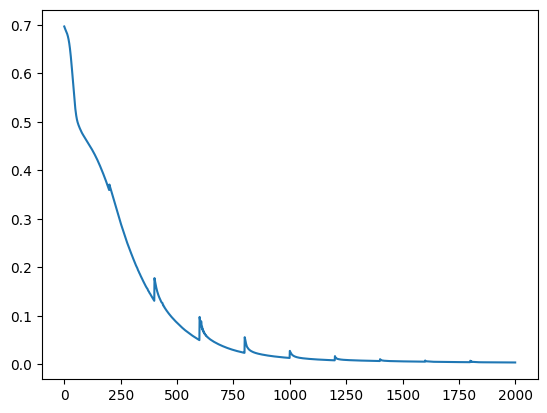

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.arange(num_epochs * folds), loss_func)